In [4]:
import pandas as pd
from pathlib import Path
import time
from tqdm.notebook import tqdm
import numpy as np
import neptune
import datetime

In [2]:
args = {}
args['data_folder'] = './Data'
args['data_filename'] = 'full_data_2014to2021.pkl'
args['summarize_n_games']= 10
args['columns_to_summarize']=['Pace', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'ORtg', 'TS%', 
                              '3PAr', 'FTr', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'DRtg']
args['summarize_method']='mean'
args['columns_order'] = ['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
                         'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
                         'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 
                         'DRB%_home', 'TRB%_home','AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home',
                         'Pace_visitor', 'eFG%_visitor','TOV%_visitor', 'ORB%_visitor', 
                         'FT/FGA_visitor', 'ORtg_visitor','TS%_visitor',
                         '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
                         'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
                         'season', 'season_nth_game', 'hometeam_nth_homegame','visitorteam_nth_visitorgame',
                         'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN']
args['home_columns_to_summarize']=[column + '_'+'home' for column in args['columns_to_summarize']]
args['visitor_columns_to_summarize']=[column + '_'+'visitor' for column in args['columns_to_summarize']]
args['processed_dataset_filename']= "ProcessedDataset_TeamBasis_mean_Past10Games_SameHomeVisitorStatus_2021-02-21.pkl"

args['random_state']=248 # RIP Kobe

In [3]:
data_folder = Path(args['data_folder'])
assert data_folder.exists()

# Read Raw Data

In [126]:
dataset_df = pd.read_pickle(data_folder/args['data_filename'])
dataset_df.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor,season,season_nth_game,hometeam_nth_homegame,visitorteam_nth_visitorgame
0,2013-10-29,ORL,87,IND,97,https://www.basketball-reference.com/boxscores/201310290IND.html,201310290IND,95.0,0.528,19.0,...,72.2,47.0,47.2,10.5,11.1,102.1,2014-2015,1,1,1
1,2013-10-29,CHI,95,MIA,107,https://www.basketball-reference.com/boxscores/201310290MIA.html,201310290MIA,97.1,0.590,17.5,...,85.7,50.6,65.7,11.3,7.7,110.2,2014-2015,2,1,1
2,2013-10-29,LAC,103,LAL,116,https://www.basketball-reference.com/boxscores/201310290LAL.html,201310290LAL,100.4,0.527,15.3,...,62.5,43.5,65.9,11.0,6.3,115.6,2014-2015,3,1,1
3,2013-10-30,BRK,94,CLE,98,https://www.basketball-reference.com/boxscores/201310300CLE.html,201310300CLE,92.3,0.446,10.0,...,63.6,43.5,72.7,8.7,11.6,106.2,2014-2015,4,1,1
4,2013-10-30,BOS,87,TOR,93,https://www.basketball-reference.com/boxscores/201310300TOR.html,201310300TOR,91.5,0.471,15.0,...,57.8,40.7,46.9,10.9,10.1,101.6,2014-2015,5,1,1


In [127]:
# convert string columns to numeric columns
for column in ['VISITOR_PTS','HOME_PTS']:
    dataset_df[column] = pd.to_numeric(dataset_df[column])

In [128]:
numeric_col=[]
for col_name in args['columns_to_summarize']:
    numeric_col.append(col_name+'_home')
    numeric_col.append(col_name+'_visitor')
numeric_col

['Pace_home',
 'Pace_visitor',
 'eFG%_home',
 'eFG%_visitor',
 'TOV%_home',
 'TOV%_visitor',
 'ORB%_home',
 'ORB%_visitor',
 'FT/FGA_home',
 'FT/FGA_visitor',
 'ORtg_home',
 'ORtg_visitor',
 'TS%_home',
 'TS%_visitor',
 '3PAr_home',
 '3PAr_visitor',
 'FTr_home',
 'FTr_visitor',
 'DRB%_home',
 'DRB%_visitor',
 'TRB%_home',
 'TRB%_visitor',
 'AST%_home',
 'AST%_visitor',
 'STL%_home',
 'STL%_visitor',
 'BLK%_home',
 'BLK%_visitor',
 'DRtg_home',
 'DRtg_visitor']

In [129]:
dataset_df[numeric_col] = dataset_df[numeric_col].astype('float')

In [130]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8743 entries, 0 to 8742
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   DATE                         8743 non-null   datetime64[ns]
 1   VISITOR                      8743 non-null   object        
 2   VISITOR_PTS                  8743 non-null   float64       
 3   HOME                         8743 non-null   object        
 4   HOME_PTS                     8743 non-null   float64       
 5   boxscores_url                8743 non-null   object        
 6   game_id                      8743 non-null   object        
 7   Pace_home                    8743 non-null   float64       
 8   eFG%_home                    8743 non-null   float64       
 9   TOV%_home                    8743 non-null   float64       
 10  ORB%_home                    8743 non-null   float64       
 11  FT/FGA_home                  8743 non-null 

In [131]:
dataset_df.columns

Index(['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
       'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
       'FT/FGA_home', 'ORtg_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home',
       'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'TS%_visitor',
       '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
       'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
       'season', 'season_nth_game', 'hometeam_nth_homegame',
       'visitorteam_nth_visitorgame'],
      dtype='object')

In [132]:
dataset_df['TOTAL_PTS'] = dataset_df['VISITOR_PTS']+dataset_df['HOME_PTS']
dataset_df['HOME_VISITOR_PTS_DIFF'] = dataset_df['HOME_PTS']-dataset_df['VISITOR_PTS']
dataset_df['HOME_WIN'] = (dataset_df['HOME_VISITOR_PTS_DIFF']>0)

In [133]:
dataset_df = dataset_df[args['columns_order']]

# Data Processing

In [ ]:
# get most recent x games data as training data
# test on 2021 data
    # sort by dates
    # iterate rows
    # get current index
    # from current index, go backwards index until found previous X games
        # if out of index before fetching X games, stop and continue (give up predicting this game)
    # if HOME or VISITOR equals to current row HOME, then get that row
    # save into a dictionary, key is game_id
    # transform as data frame, and join with the full data
# average
# 2 teams, concatenate to the same row
# predict

In [182]:
# shift games downward by 1 row, so when calculating rolling 10 games, game to predict is not included
shifted=pd.merge(dataset_df[['DATE','HOME','game_id','season']],dataset_df.groupby(['season','HOME']).shift(1).dropna(how='any')[args['home_columns_to_summarize']],left_index=True,right_index=True)
home_summarized = shifted.rename_axis(index='game_index').sort_values(by='DATE').groupby(['season','HOME']).rolling(args['summarize_n_games']).mean().dropna(how='all')[args['home_columns_to_summarize']].droplevel(level=[0,1])
print(home_summarized.shape)
home_summarized.head()

(6360, 15)


,Pace_home,eFG%_home,TOV%_home,ORB%_home,FT/FGA_home,ORtg_home,TS%_home,3PAr_home,FTr_home,DRB%_home,TRB%_home,AST%_home,STL%_home,BLK%_home,DRtg_home
game_index,,,,,,,,,,,,,,,
311,93.73,0.5085,13.20,19.85,0.2087,105.01,0.5450,0.2571,0.2812,77.64,49.72,67.25,7.34,7.62,101.13
330,94.43,0.4961,13.27,20.20,0.2068,103.26,0.5352,0.2571,0.2719,77.81,49.59,68.32,7.58,7.90,101.03
355,94.01,0.4916,13.48,20.22,0.2137,102.39,0.5326,0.2596,0.2800,76.61,48.73,67.06,7.62,7.10,100.99
370,94.26,0.4978,12.92,21.32,0.2070,104.63,0.5376,0.2577,0.2690,75.38,48.19,68.33,8.61,6.97,101.25
382,93.84,0.5108,13.07,22.22,0.1946,106.25,0.5476,0.2602,0.2529,75.67,48.66,70.01,8.74,7.09,102.11


In [183]:
shifted=pd.merge(dataset_df[['DATE','VISITOR','game_id','season']],dataset_df.groupby(['season','VISITOR']).shift(1).dropna(how='any')[args['visitor_columns_to_summarize']],left_index=True,right_index=True)
visitor_summarized = shifted.rename_axis(index='game_index').sort_values(by='DATE').groupby(['season','VISITOR']).rolling(args['summarize_n_games']).mean().dropna(how='all')[args['visitor_columns_to_summarize']].droplevel(level=[0,1])
print(visitor_summarized.shape)
visitor_summarized.head()

(6356, 15)


,Pace_visitor,eFG%_visitor,TOV%_visitor,ORB%_visitor,FT/FGA_visitor,ORtg_visitor,TS%_visitor,3PAr_visitor,FTr_visitor,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor
game_index,,,,,,,,,,,,,,,
257,95.59,0.5182,14.31,20.29,0.2100,105.27,0.5537,0.2844,0.2830,76.56,47.82,63.58,10.00,8.10,107.78
343,94.96,0.5138,13.66,21.08,0.1797,105.03,0.5450,0.2851,0.2421,76.19,47.90,61.52,9.47,7.49,106.86
409,93.58,0.5364,15.44,21.94,0.1808,106.89,0.5690,0.3092,0.2299,73.95,48.10,60.52,9.27,7.17,109.08
421,93.40,0.5410,15.65,22.52,0.1727,107.41,0.5721,0.3194,0.2187,73.82,48.41,60.44,8.79,6.39,110.33
447,93.26,0.5459,16.27,22.08,0.1725,107.37,0.5768,0.3247,0.2169,73.59,48.19,59.70,8.79,5.59,109.92


In [184]:
processed_dataset=pd.concat([dataset_df.rename_axis('game_index')[['DATE','VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url','game_id']],
          home_summarized,
          visitor_summarized],join='inner',axis=1)
processed_dataset['TOTAL_PTS'] = processed_dataset['VISITOR_PTS']+processed_dataset['HOME_PTS']
processed_dataset['HOME_VISITOR_PTS_DIFF'] = processed_dataset['HOME_PTS']-processed_dataset['VISITOR_PTS']
processed_dataset['HOME_WIN'] = (processed_dataset['HOME_VISITOR_PTS_DIFF']>0)
processed_dataset.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,FTr_visitor,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor,TOTAL_PTS,HOME_VISITOR_PTS_DIFF,HOME_WIN
game_index,,,,,,,,,,,,,,,,,,,,,
270,2013-12-04,PHO,97.0,HOU,88.0,https://www.basketball-reference.com/boxscores/201312040HOU.html,201312040HOU,96.16,0.5589,16.79,...,0.2537,74.86,48.75,54.12,8.35,6.32,106.67,185.0,-9.0,False
283,2013-12-06,GSW,83.0,HOU,105.0,https://www.basketball-reference.com/boxscores/201312060HOU.html,201312060HOU,96.65,0.5459,16.93,...,0.2909,77.03,51.29,56.93,8.59,8.28,100.93,188.0,22.0,True
288,2013-12-07,DEN,103.0,PHI,92.0,https://www.basketball-reference.com/boxscores/201312070PHI.html,201312070PHI,97.62,0.5038,16.31,...,0.3110,70.69,50.35,53.79,8.34,7.41,108.99,195.0,-11.0,False
291,2013-12-07,GSW,108.0,MEM,82.0,https://www.basketball-reference.com/boxscores/201312070MEM.html,201312070MEM,89.15,0.4992,15.07,...,0.3139,76.60,50.73,53.80,7.85,7.72,103.24,190.0,-26.0,False
302,2013-12-09,GSW,111.0,CHA,115.0,https://www.basketball-reference.com/boxscores/201312090CHA.html,201312090CHA,91.08,0.4437,12.51,...,0.3060,75.13,50.62,53.77,7.43,6.90,104.23,226.0,4.0,True


In [186]:
# TODO: automatically populate dataset name, model name
processed_dataset.to_pickle(data_folder/(args['processed_dataset_filename']))

# Models

## Team based - simple average of past xx games


# Generate Training/Validation/Test Data

In [187]:
# import libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from dtreeviz.trees import *

In [188]:
# load the processed data
teamstats = pd.read_pickle(data_folder/(args['processed_dataset_filename']))
teamstats = add_datepart(teamstats, 'DATE')
teamstats.columns

Index(['VISITOR', 'VISITOR_PTS', 'DATEWeek', 'HOME', 'HOME_PTS',
       'boxscores_url', 'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home',
       'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home',
       'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home',
       'BLK%_home', 'DRtg_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor',
       'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor',
       'DRtg_visitor', 'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN',
       'DATEYear', 'DATEMonth', 'DATEDay', 'DATEDayofweek', 'DATEDayofyear',
       'DATEIs_month_end', 'DATEIs_month_start', 'DATEIs_quarter_end',
       'DATEIs_quarter_start', 'DATEIs_year_end', 'DATEIs_year_start',
       'DATEElapsed'],
      dtype='object')

In [189]:
# teamstats['DRtg_home']=100
# teamstats['DRtg_visitor']=100

In [190]:
sum(teamstats['HOME_WIN'])/len(teamstats['HOME_WIN'])

0.5809956218582779

In [191]:
# set what are dependent variables, what are independent variables
args['dep_variable'] = ['HOME_WIN']
args['ind_variable'] = args['home_columns_to_summarize']+args['visitor_columns_to_summarize']

In [192]:
other_idx,test_idx = train_test_split(list(teamstats.index),test_size=0.1,random_state=args['random_state'])
test_set = teamstats.loc[test_idx,args['ind_variable']+args['dep_variable']].copy()
# don't want to mix non-test set with training set, therefore "other_set"
other_set = teamstats.loc[other_idx,args['ind_variable']+args['dep_variable']].copy()
train_idx,valid_idx = train_test_split(list(other_set.reset_index(drop=True).index),test_size=0.2,random_state=args['random_state'])
[len(idx) for idx in [train_idx,valid_idx,test_idx]]

[4440, 1110, 617]

In [193]:
# split continuous variables and categorical variabls
cont_var, cat_var=cont_cat_split(other_set,1,dep_var=args['dep_variable'])
print(cont_var,cat_var)

['Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'Pace_visitor', 'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor', 'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor'] []


In [194]:
# return a tabular object
to=TabularPandas(other_set,cat_names=cat_var,cont_names=cont_var,
                 y_names=args['dep_variable'],splits=(train_idx,valid_idx))
len(to.train),len(to.valid)

(4440, 1110)

In [195]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
print(len(xs))
print(len(valid_xs))

4440
1110


# Initialize Neptune to Record Experiments

In [5]:
neptune.init(project_qualified_name='jjnotjimmyjohn/NBA-Score-Prediction')
# neptune.init(project_qualified_name='jjnotjimmyjohn/sandbox',api_token=neptune.ANONYMOUS_API_TOKEN)

Project(jjnotjimmyjohn/NBA-Score-Prediction)

# Decision Tree

In [196]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
from sklearn.metrics import SCORERS,accuracy_score,f1_score

In [197]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[10,20,30,40,60],
    'max_features':[0.5,0.6,0.7,0.8,0.9],
}
# base model
base_model = DecisionTreeClassifier(random_state=args['random_state'])

In [198]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=90,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   10.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   15.5s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:   21.2s
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:   23.0s finished


RandomizedSearchCV(cv=8, estimator=DecisionTreeClassifier(random_state=248),
                   n_iter=90, n_jobs=6,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             60],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [199]:
print(accuracy_score(y,model.predict(xs)))
print(accuracy_score(valid_y,model.predict(valid_xs)))

0.7157657657657658
0.581081081081081


In [6]:
neptune.create_experiment(name='test_experiment',description='just testing API')
neptune.stop()

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://ui.neptune.ai/jjnotjimmyjohn/NBA-Score-Prediction/e/NBAS-4


In [ ]:
# create experiment
# neptune.set_project('jjnotjimmyjohn/NBA-Score-Prediction')
neptune.create_experiment(name='TeamBasedModel_moredata',description='',params=model.get_params())
neptune.append_tag(f'summarize_past_games')
neptune.append_tag(f'decision_tree')
neptune.append_tag(f'randomized_search_cv')
neptune.log_metric('training_error', mean_absolute_error(y,model.predict(xs)))
neptune.log_metric('validation_error', mean_absolute_error(valid_y,model.predict(valid_xs)))
neptune.log_text('best_model', str(model.best_estimator_))
for key,value in args.items():
    neptune.set_property(key,value)
neptune.stop()

# Randome Forest

In [200]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'max_samples':[0.5,0.7,0.8,0.9,1],
    'min_samples_leaf':[30,40,50],
    'max_features':[0.6,0.7,0.8,0.9,1],
}
# base model


In [209]:
base_model = RandomForestClassifier(n_jobs=-1, n_estimators=2000, oob_score=True, min_samples_leaf=45)
base_model.fit(xs,y)
print(accuracy_score(y,base_model.predict(xs)))
print(accuracy_score(valid_y,base_model.predict(valid_xs)))

0.7132882882882883
0.663963963963964


In [207]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=100,n_jobs=-1,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 98.2min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed: 145.4min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 188.2min finished


RandomizedSearchCV(cv=8,
                   estimator=RandomForestClassifier(min_samples_leaf=50,
                                                    n_estimators=2000,
                                                    n_jobs=-1, oob_score=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'max_samples': [0.5, 0.7, 0.8, 0.9, 1],
                                        'min_samples_leaf': [10, 15, 25],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [208]:
print(accuracy_score(y,model.predict(xs)))
print(accuracy_score(valid_y,model.predict(valid_xs)))

0.9
0.6549549549549549


In [98]:
model.best_estimator_.feature_importances_

array([0.01755608, 0.04531653, 0.02353935, 0.01787496, 0.01776416,
       0.10482879, 0.04499968, 0.01649685, 0.0171083 , 0.0172028 ,
       0.02323076, 0.022981  , 0.01970445, 0.02227803, 0.1129221 ,
       0.01967865, 0.05323375, 0.01790268, 0.01876028, 0.01907   ,
       0.06575033, 0.05444263, 0.01928852, 0.01686225, 0.01832983,
       0.02606629, 0.01953459, 0.02087306, 0.02032816, 0.08607512])

In [99]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [100]:
fi = rf_feat_importance(model.best_estimator_, xs)
fi

,cols,imp
14,DRtg_home,0.112922
5,ORtg_home,0.104829
29,DRtg_visitor,0.086075
20,ORtg_visitor,0.065750
21,TS%_visitor,0.054443
16,eFG%_visitor,0.053234
1,eFG%_home,0.045317
6,TS%_home,0.045000
25,TRB%_visitor,0.026066
2,TOV%_home,0.023539


# XGBoost

In [210]:
import xgboost as xg

In [225]:
xgb_r = xg.XGBClassifier(n_estimators = 9, seed = args['random_state'],max_depth=4,reg_lambda=0.1)
xgb_r.fit(xs,y)

[04:36:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=9, n_jobs=6, num_parallel_tree=1, random_state=248,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=248,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [226]:
print(accuracy_score(y,xgb_r.predict(xs)))
print(accuracy_score(valid_y,xgb_r.predict(valid_xs)))

0.7063063063063063
0.6414414414414414


In [227]:
print(valid_y[:10])
print(xgb_r.predict(valid_xs)[:10])

game_index
4251    1
1978    1
4337    1
8305    0
5237    1
2211    0
7320    0
6820    1
5334    1
755     0
Name: HOME_WIN, dtype: int8
[1 1 1 1 1 1 1 0 1 1]


# Neural Networks

In [228]:
from fastai import *
to_nn = to.copy()
dls = to_nn.dataloaders(1024)

In [229]:
y = to_nn.train.y
y.min(),y.max()

(0, 1)

In [230]:
learn = tabular_learner(dls, layers=[3000,1500,1000,250], metrics=accuracy)

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.43651583790779114)

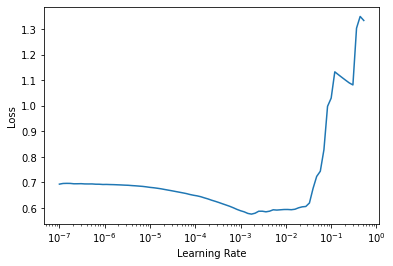

In [231]:
learn.lr_find()

In [232]:
learn.fit_one_cycle(5,0.0007)

epoch,train_loss,valid_loss,accuracy,time
0,0.661949,0.697338,0.598198,00:04
1,0.625572,0.681520,0.598198,00:04
2,0.587827,0.777778,0.598198,00:04
3,0.548909,0.769263,0.598198,00:03
4,0.516257,0.754807,0.598198,00:03


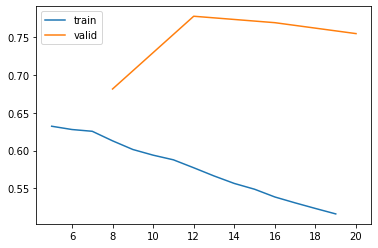

In [233]:
learn.recorder.plot_loss()

In [234]:
preds,targs = learn.get_preds()

In [236]:
accuracy_score(targs,np.argmax(preds, 1))

0.5981981981981982

In [ ]:
## Model - team based - similar opponents as training data
获取球队最近几场与相似对手交手时，取得的数据作为training data

相似对手：

1. 将ortg和drtg作为x轴y轴，几何距离最近的对手

1. 用什么的ortg，drtg？所有本赛季已进行的比赛的数据？单场？

In [ ]:
## Model - Player based

In [ ]:
# players? -> include minutes played
# injured players?
# use news to guess how many minutes he will play